# **Analyzing and Predicting Housing Prices in Sakarya, Turkey: A Data-Driven Approach**





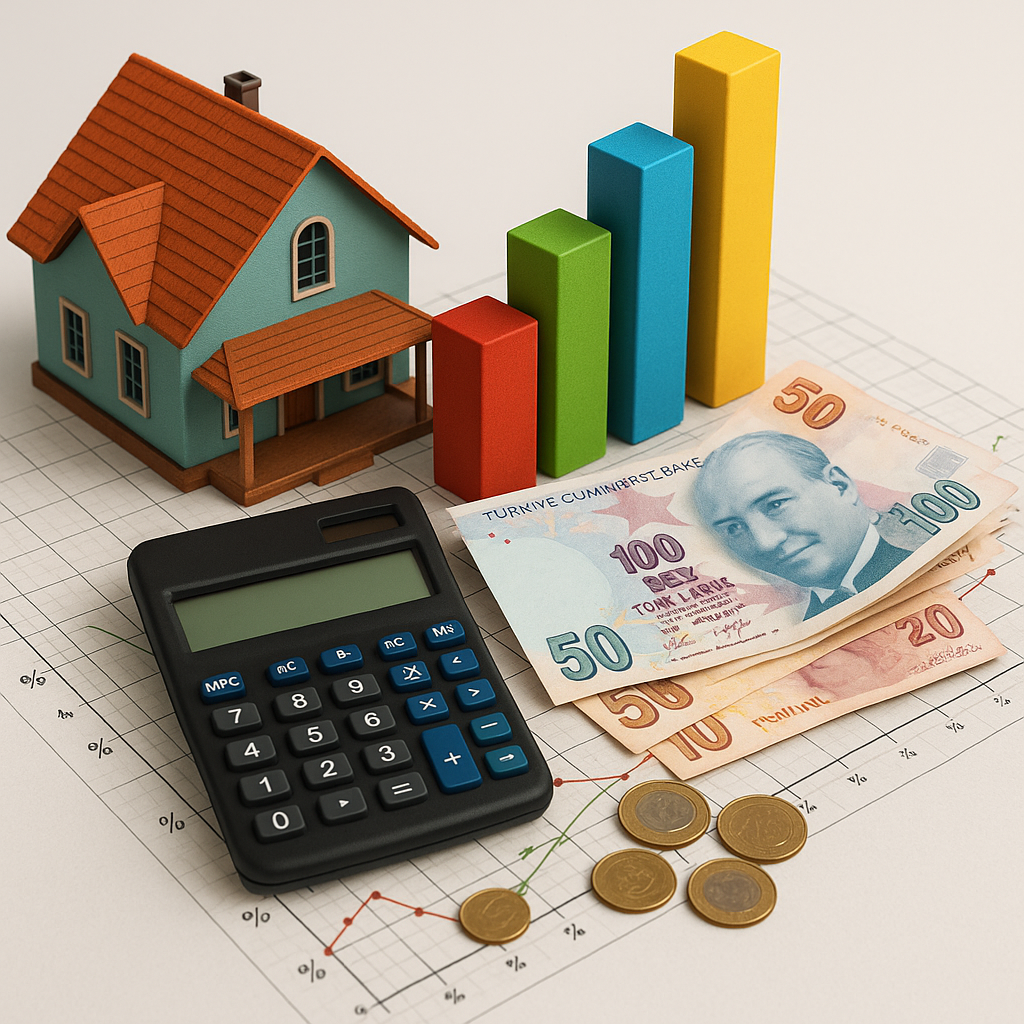

#**Libraries Used In The Project and Data Loading**

In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import randint
import time
import joblib
import scipy.stats as st
from sklearn.model_selection import KFold, cross_validate, train_test_split





In [ ]:
data = pd.read_csv('/content/veri.csv')

# **Functions Used In The Project**

In [ ]:
def normalize_distribution(df, column, method, show_plots=True, offset=1):

    result_df = df.copy()

    transformed_column = column

    if method == 'log':
            result_df[transformed_column] = np.log(result_df[column])

    elif method == 'log10':
            result_df[transformed_column] = np.log10(result_df[column])


    elif method == 'log1p':
        result_df[transformed_column] = np.log1p(result_df[column])

    elif method == 'log1pp':
        result_df[transformed_column] =  np.log1p(np.log1p(result_df[column]))

    elif method == 'sqrt':
            result_df[transformed_column] = np.sqrt(result_df[column])

    elif method == 'cube_root':
        result_df[transformed_column] = np.cbrt(result_df[column])

    elif method == 'reciprocal':
            result_df[transformed_column] = 1 / result_df[column]

    elif method == 'box-cox':
        adjusted_values = result_df[column]

        transformed_values, lambda_value = stats.boxcox(adjusted_values)
        result_df[transformed_column] = transformed_values
        print(f"Paramètre lambda pour Box-Cox: {lambda_value:.4f}")

    elif method == 'yeo-johnson':
        pt = PowerTransformer(method='yeo-johnson')
        result_df[transformed_column] = pt.fit_transform(result_df[[column]])
        print(f"Paramètre lambda pour Yeo-Johnson: {pt.lambdas_[0]:.4f}")

    elif method == 'quantile':
        qt = QuantileTransformer(output_distribution='normal')
        result_df[transformed_column] = qt.fit_transform(result_df[[column]])

    else:
        raise ValueError("Méthode non reconnue. Utilisez 'log', 'log10','log1p', 'sqrt', 'box-cox', 'yeo-johnson', 'quantile', 'reciprocal', ou 'cube_root'")

    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        sns.histplot(df[column], kde=True, ax=axs[0])
        axs[0].set_title('original distribution:')
        axs[0].set_xlabel(column)
        axs[0].set_ylabel('Fréquence')

        sns.histplot(result_df[transformed_column], kde=True, ax=axs[1])
        axs[1].set_title(f'Distribution after transformation {method}')
        axs[1].set_xlabel(f'{column} ({method})')
        axs[1].set_ylabel('Fréquence')

        plt.tight_layout()
        plt.show()

        print("Statistics of original distribution:")
        print(df[column].describe())
        print(f"\nStatistics after transformation {method}:")
        print(result_df[transformed_column].describe())
    return result_df

def remove_outlier(col):
    if col.dtype == 'bool':
        col = col.astype(int)

    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lr= Q1-(1.5 * IQR)
    ur= Q3+(1.5 * IQR)
    return lr, ur

def collapse_rare(series, min_pct=0.01):
    freqs = series.value_counts(normalize=True)
    to_keep = freqs[freqs >= min_pct].index
    return series.where(series.isin(to_keep), other="Unknown")


def predict_with_xgboost_pipeline(new_input, model_path='xgboost_pipeline_model.pkl'):
    model = joblib.load(model_path)

    if isinstance(new_input, dict):
        new_input_df = pd.DataFrame([new_input])
    elif isinstance(new_input, pd.DataFrame):
        new_input_df = new_input.copy()
    else:
        raise ValueError("Input must be a dictionary or pandas DataFrame.")

    # Make prediction
    prediction = model.predict(new_input_df)[0]

    return round(prediction, 2)


# Skewness transformation function
def transform_skewed_columns(df):
    skewed_cols = df.select_dtypes(include=[np.number]).columns
    transformed_df = df.copy()

    for col in skewed_cols:
        sk = skew(transformed_df[col].dropna())
        if sk > 1:
            # Right-skewed
            transformed_df[col] = np.log1p(transformed_df[col])
        elif sk < -1:
            # Left-skewed
            max_val = transformed_df[col].max()
            transformed_df[col] = np.log1p(max_val + 1 - transformed_df[col])

    return transformed_df


# **Data Preprocessing**

In [ ]:
print(data.shape)
data.head(2)

(2160, 135)


,listingId,realtyId,no,title,descriptionPhoneNumbers,description,price,currency,currencyId,startDate,...,realtyIdentificationNo,listingPropertyOrder,listingId.1,curr rency,ccurrency,enddDate,curreency,endDaate,are eas,ccurrencyId
0,78883-704,43672903,704,ÇİFTÇİ EMLAK 'tan BİLGE HAST. YANI ARA KAT ANA...,[],"<h2 style=\""text-align: center;\""><strong styl...",2500000,TL,1.0,2025-02-07T07:33:35.387+0000,...,NaN,"{""fuelName"":15,""city"":2,""roomAndLivingRoom"":8,...",78883-704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54537-3457,42399668,3457,SAKARYA KARASU'DA YAZLIK DAİRENİZ EMRE FİLİZFİ...,[],"<p style=\""text-align: center;\""><br></p>\n<p ...",1500000,TL,1.0,2025-01-10T11:50:32.547+0000,...,NaN,"{""fuelName"":15,""city"":2,""roomAndLivingRoom"":8,...",54537-3457,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let drop the columns that are not needed for the Price Prediction

In [ ]:
print(data.columns.tolist())

['listingId', 'realtyId', 'no', 'title', 'descriptionPhoneNumbers', 'description', 'price', 'currency', 'currencyId', 'startDate', 'endDate', 'publishId', 'housingEstate', 'useContactInfo', 'contact', 'bid', 'images', 'locationId', 'areas', 'district', 'county', 'city', 'address', 'showAddress', 'residence', 'timeShareName', 'timeShareTerm', 'room', 'livingRoom', 'bathRoom', 'advertiseOwner', 'isMapHidden', 'mapLocation', 'mapZoomLevel', 'streetView', 'createdDate', 'updatedDate', 'listingUpdatedDate', 'showPrice', 'projectId', 'sqm', 'numberOfBuilding', 'entranceHeight', 'bedCount', 'floor', 'age', 'heating', 'fuel', 'build', 'buildState', 'star', 'land', 'usage', 'credit', 'deposit', 'flatReceived', 'barter', 'byTransfer', 'registerId', 'landRegisterName', 'populated', 'areaIds', 'housingComplex', 'dormitory', 'rental', 'activateId', 'authorizedRealtor', 'cleanLandRegisterStateTypeId', 'cleanLandRegisterFilePath', 'furnished', 'balcony', 'parking', 'detailUrl', 'redirectLink', 'detai

In [ ]:
columns_to_drop = [
    'listingId', 'realtyId', 'no', 'title', 'descriptionPhoneNumbers',
    'description', 'currency', 'currencyId','contact', 'images', 'isMapHidden','flatReceived',
    'byTransfer', 'detailUrl', 'redirectLink','timeShareName','timeShareTerm',
    'detailDescription', 'firm', 'firmUser','fee','streetView','mapLocation',
    'videoUrl', 'isVideoTypeVimeo', 'stale','land','deposit','byTransfer', 'startDate', 'endDate',
    'searchScore', 'tagProducts', 'featuringProducts', 'whatsAppNumber',
    'virtualTour', 'onlineVisit', 'hasBranded', 'hasUpdateBooster','dormitory',
    'floorAreaRatio','realtyOwnerUrl','populated','areaIds','rental', 'activateId',
    'cleanLandRegisterStateTypeId', 'cleanLandRegisterFilePath','additionalGuestFee',
    'cleaningFee', 'entertainmentAllowed','balcony', 'parking', 'holdDate', 'nearLocation',
    'parentCategoryId', 'category','attributes', 'mainCategory', 'superRealty', 'imageCapacity',
    'guestCount', 'invoiceIncluded', 'maximumStay', 'minimumStay','petAllowed', 'doubleBedCount',
    'singleBedCount','realtyIdentificationNo', 'listingPropertyOrder',
    'attributeCapacity', 'productCount', 'gabarite', 'groundStudies',
    'additionalGuestFeeCurrency', 'checkInTime', 'checkOutTime', 'cleaningFeeCurrency',
    'period', 'fixedDailyPrice', 'fixedDailyPriceCurrencyId', 'realtyPermitDocumentNo','roomAndLivingRoom',
    'listingId.1', 'curr rency', 'ccurrency', 'enddDate','createdDate', 'updatedDate', 'listingUpdatedDate',
    'curreency', 'endDaate', 'are   eas', 'ccurrencyId'
]


In [ ]:
data = data.drop(columns=columns_to_drop)

print("Remaining columns:", data.columns.tolist())

Remaining columns: ['price', 'publishId', 'housingEstate', 'useContactInfo', 'bid', 'locationId', 'areas', 'district', 'county', 'city', 'address', 'showAddress', 'residence', 'room', 'livingRoom', 'bathRoom', 'advertiseOwner', 'mapZoomLevel', 'showPrice', 'projectId', 'sqm', 'numberOfBuilding', 'entranceHeight', 'bedCount', 'floor', 'age', 'heating', 'fuel', 'build', 'buildState', 'star', 'usage', 'credit', 'barter', 'registerId', 'landRegisterName', 'housingComplex', 'authorizedRealtor', 'furnished', 'subCategory', 'sides', 'registerState']


In [ ]:
missing_percentage = data.isna().sum() / data.shape[0]
print(missing_percentage)

price                0.000000
publishId            1.000000
housingEstate        1.000000
useContactInfo       1.000000
bid                  1.000000
locationId           1.000000
areas                0.000463
district             0.000000
county               0.000000
city                 0.000000
address              1.000000
showAddress          1.000000
residence            0.468056
room                 0.000000
livingRoom           0.000000
bathRoom             0.000000
advertiseOwner       1.000000
mapZoomLevel         1.000000
showPrice            1.000000
projectId            1.000000
sqm                  0.000000
numberOfBuilding     0.034722
entranceHeight       0.034722
bedCount             0.034722
floor                0.000000
age                  0.034722
heating              0.034722
fuel                 0.478241
build                0.488426
buildState           0.439352
star                 1.000000
usage                0.084259
credit               0.034722
barter    

In [ ]:
columns_to_remove = data.columns[data.isna().sum() / data.shape[0] == 1]
print("Columns with 100% null values:")
print(columns_to_remove.tolist())

Columns with 100% null values:
['publishId', 'housingEstate', 'useContactInfo', 'bid', 'locationId', 'address', 'showAddress', 'advertiseOwner', 'mapZoomLevel', 'showPrice', 'projectId', 'star', 'registerId']


In [ ]:
data = data.drop(columns=columns_to_remove)

In [ ]:
data.shape

(2160, 29)

In [ ]:
data.duplicated().sum()

np.int64(69)

In [ ]:
data = data.drop_duplicates()
print("\nNumber of datapoints after dropping duplicates:", len(data))


Number of datapoints after dropping duplicates: 2091


In [ ]:
def extract_number_from_string(val):
    if isinstance(val, str) and val.startswith('[') and val.endswith(']'):
        try:
            return int(val.strip('[]'))
        except:
            return val
    return val

data['room'] = data['room'].apply(extract_number_from_string)
data['livingRoom'] = data['livingRoom'].apply(extract_number_from_string)


In [ ]:

def extract_name(val):
    if isinstance(val, str):
        try:
            val = json.loads(val)
        except:
            return val

    if isinstance(val, list):
        if len(val) == 0:
            return 'Unknown'
        if isinstance(val[0], dict):
            return val[0].get('name')

    if isinstance(val, dict):
        if 'typeName' in val:
            return val.get('typeName')
        return val.get('name')

    return val

columns_to_transform = ['areas', 'district', 'county', 'city', 'residence','heating','fuel','build','buildState','usage','credit','barter','housingComplex','subCategory','sides']

for col in columns_to_transform:
    data[col] = data[col].apply(extract_name)

print(data[columns_to_transform].head())


      areas           district     county     city residence heating  \
0  İstiklal           Kurtuluş  Adapazarı  Sakarya     Daire   Kombi   
1     Diğer               Yalı     Karasu  Sakarya       NaN   Kombi   
2     Diğer  Kırkpınar Soğuksu    Sapanca  Sakarya   Dubleks   Kombi   
3     Diğer            Kabakoz     Karasu  Sakarya     Daire   Kombi   
4     Diğer              Yayla    Kocaali  Sakarya  Tripleks   Kombi   

       fuel      build buildState usage credit    barter housingComplex  \
0  Doğalgaz  Betonarme  İkinci El   Boş  Uygun  Yapılmaz            NaN   
1       NaN        NaN        NaN   Boş  Uygun   Yapılır            NaN   
2  Doğalgaz  Betonarme  İkinci El   Boş  Uygun  Yapılmaz            NaN   
3  Doğalgaz        NaN      Sıfır   Boş  Uygun   Yapılır           Evet   
4  Doğalgaz  Betonarme      Sıfır   Boş  Uygun   Yapılır            NaN   

  subCategory    sides  
0       Daire    Kuzey  
1       Daire    Kuzey  
2       Villa  Unknown  
3       Daire  U

In [ ]:
def extract_net_sqm(val):
    if isinstance(val, str):
        try:
            val = json.loads(val)
        except:
            return None
    if isinstance(val, dict):
        return val.get('netSqm')
    return None

def extract_gross_sqm(val):
    if isinstance(val, str):
        try:
            val = json.loads(val)
        except:
            return None
    if isinstance(val, dict):
        gross = val.get('grossSqm')
        if isinstance(gross, list) and len(gross) > 0:
            return gross[0]
    return None

data['netSqm'] = data['sqm'].apply(extract_net_sqm)
data['grossSqm'] = data['sqm'].apply(extract_gross_sqm)

data.drop(columns='sqm', inplace=True)



In [ ]:
def extract_floor_count(val):
    if isinstance(val, str):
        try:
            val = json.loads(val)
        except:
            return None
    if isinstance(val, dict):
        return val.get('count')
    return None
data['floor'] = data['floor'].apply(extract_floor_count)


##**Missing data, label encoding, and factorizing variables**

First of all, let see which variables contain missing values.

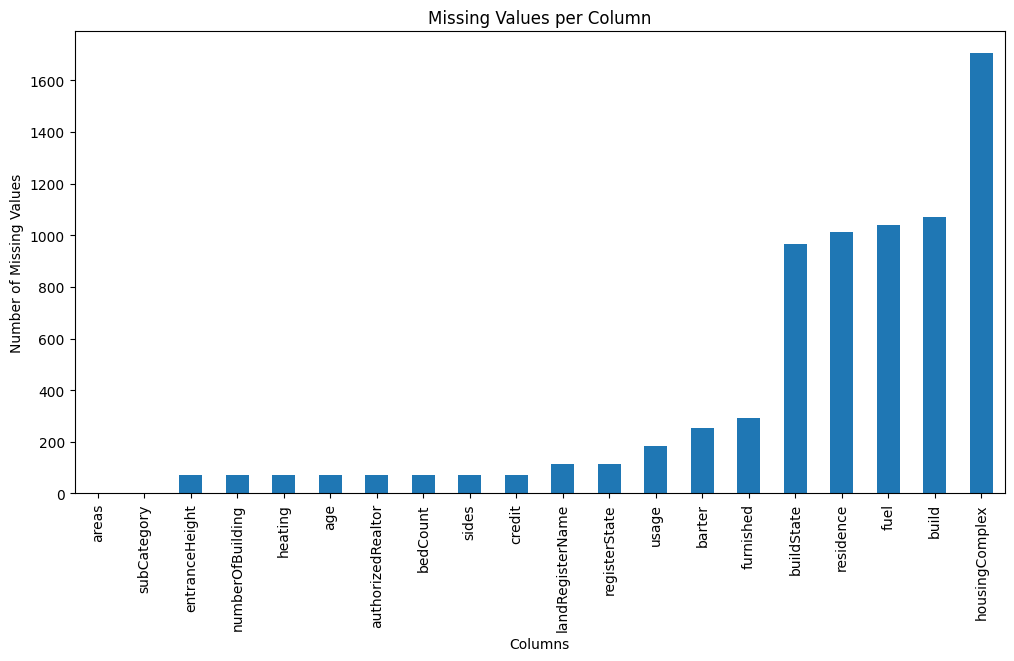

In [ ]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize=(12, 6))
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()


In [ ]:
columns_with_nulls = data.columns[data.isnull().sum() > 0]

for col in columns_with_nulls:
    print(f"Value counts for column: {col}")
    print(data[col].value_counts(dropna=False), "\n")  # dropna=False will include NaN in value counts


Value counts for column: areas
areas
Diğer              1177
Serdivan Merkez     187
Kırsal Mahalle      148
Sapanca Merkez       77
Unknown              73
Karaman              64
Tığcılar             48
İstiklal             44
Diger                40
Erenler Merkez       38
Arifiye Merkez       36
Semerciler           34
Karaosman            32
Tepekum              21
Akyazı Merkez        12
SerdivanMerkez        9
Erenler               7
Söğütlü Merkez        6
Dibektaş              6
Kuzuluk               6
Yavuzselim            3
SapancaMerkez         3
KırsalMahalle         2
Di�er                 2
Küçücek               2
Tigcilar              2
Kirsal Mahalle        2
Ahiler                1
Lahna                 1
Bedılkazancı          1
NaN                   1
OSB                   1
Dokurcun              1
Akyazi Merkez         1
Istiklal              1
ErenlerMerkez         1
ArifiyeMerkez         1
Name: count, dtype: int64 

Value counts for column: residence
residence
Na

In [ ]:

for col in ['areas', 'sides']:
    data[col] = data[col].astype(str)


In [ ]:
# 1. residence
residence_map = {
    'Daire':          'Daire',
    'Tripleks':       'Tripleks',
    'Müstakil Ev':    'Müstakil Ev',
    'MüstakilEv':     'Müstakil Ev',
    'Dubleks':        'Dubleks',
    'Bahçe Katı':     'Bahçe Katı',
    'BahçeKatı':      'Bahçe Katı',
    'Bahçe Dubleksi': 'Bahçe Dubleksi',
    'BahçeDubleksi': 'Bahçe Dubleksi',
    'Çatı Dubleksi':  'Çatı Dubleksi',
    '�ati Dubleksi':  'Çatı Dubleksi',
    'Ters Dubleks':   'Ters Dubleks',
    'Ara Kat Dubleks':'Ara Kat Dubleks',
    'İkiz Ev':        'İkiz Ev',
    None:             'Unknown',
    'None':           'Unknown',
}
data['residence'] = (
    data['residence']
      .replace(residence_map)
      .fillna('Other')
)

# 2. build
build_map = {
    'Betonarme':              'Betonarme',
    'Reinforced Concrete':    'Betonarme',
    'Bet tonarme':            'Betonarme',
    'Taş Bina':               'Taş Bina',
    'TaşBina':                'Taş Bina',
    'Kagir':                  'Kagir',
    'Ahşap':                  'Ahşap',
    'Çelik':                  'Çelik',
    'Yığma':                  'Yığma',
    'Prefabrik':              'Prefabrik',
    None:                     'Unknown',
    'None':                   'Unknown',
}
data['build'] = data['build'].replace(build_map).fillna('Unknown')

# 3. buildState
build_state_map = {
    'Sıfır':               'Sıfır',
    'Sifir':               'Sıfır',
    '0':                   'Sıfır',
    'İkinci El':           'İkinci El',
    'Ikinci El':            'İkinci El',
    'İkinciEl':            'İkinci El',
    'IkinciEl':            'İkinci El',
    'Second Hand':         'İkinci El',
    'Kiracılı':            'İkinci El',
    'Yapım Aşamasında':    'Sıfır',
    None:                  'Unknown',
    'None':                'Unknown',
}
data['buildState'] = data['buildState'].replace(build_state_map).fillna('Unknown')

# 4. usage
usage_map = {
    'Boş':               'Boş',
    'Bos':               'Boş',
    'Bo�':               'Boş',
    'Empty':             'Boş',
    'Mülk Sahibi':       'Mülk Sahibi',
    'MülkSahibi':        'Mülk Sahibi',
    'M�lk Sahibi':       'Mülk Sahibi',
    'Owner':             'Mülk Sahibi',
    'Kiracılı':          'Kiracılı',
    'Kiracili':          'Kiracılı',
    'Tenanted':          'Kiracılı',
    'Belirtilmemiş':     np.nan,
    None:                np.nan,
    'None':              'Unknown',
}
data['usage'] = data['usage'].replace(usage_map)

# 5. credit
credit_map = {
    'Uygun':            'Uygun',
    'Available':        'Uygun',
    'Uygun değil':      'Uygun değil',
    'Uygundeğil':       'Uygun değil',
    'Uygun degil':      'Uygun değil',
    'Uygun de�il':      'Uygun değil',
    'Not Available':    'Uygun değil',
    'Notavail':         'Uygun değil',
    'Bilinmiyor':       np.nan,
    'None':             np.nan,
}
data['credit'] = data['credit'].replace(credit_map)

# 6. barter
barter_map = {
    'Yapılır':    'Yapilir',
    'Yapilir':    'Yapilir',
    'Makes':      'Yapilir',
    'Yap�l�r':    'Yapilir',
    'Yapılmaz':   'Yapilmaz',
    'Yapilmaz':   'Yapilmaz',
    'Yap�lmaz': 'Yapilmaz',
    'Not Done':   'Yapilmaz',
    'None':       np.nan,
}
data['barter'] = data['barter'].replace(barter_map)

# 7. landRegisterName
land_map = {
    'Kat Mülkiyeti':     'Kat Mülkiyeti',
    'KatMülkiyeti':      'Kat Mülkiyeti',
    'Kat M�lkiyeti':     'Kat Mülkiyeti',
    'Condominium':       'Kat Mülkiyeti',
    'Kat İrtifakı':      'Kat İrtifakı',
    'Katİrtifakı':       'Kat İrtifakı',
    'Kat Irtifaki':      'Kat İrtifakı',
    'Kat �rtifak�':      'Kat İrtifakı',
    'Floor Easement':    'Kat İrtifakı',
    'Tapu Yok':          'Tapu Yok',
    'TapuYok':           'Tapu Yok',
    'Arsa':              'Arsa',
    'Yabancıdan':              'Yabancidan',
    'None':              np.nan,
}
data['landRegisterName'] = data['landRegisterName'].replace(land_map)


# 9. subCategory
subcat_map = {
    'Daire':                   'Daire',
    'Apartment':               'Daire',
    'Villa':                   'Villa',
    'Yazlık':                  'Villa',
    'Bungalov':                'Villa',
    'Seaside&Summer House':    'Villa',
    'Müstakil Ev':             'House',
    'MüstakilEv':              'House',
    'M�stakil Ev':              'House',
    'Çiftlik Evi':             'House',
    'Köy Evi':                 'House',
    'Detached House':          'House',
    'Bina':                    'Building',
    'Prefabrik':               'Building',
    'Köşk':                    'Building',
    'Residence':               'Building',
}
data['subCategory'] = data['subCategory'].replace(subcat_map)

#10 areas
areas_map = {
    'Diger': 'Diğer',
    'Di�er': 'Diğer',
    'Kirsal Mahalle': 'Kırsal Mahalle',
    'KirsalMahalle': 'Kırsal Mahalle',
    'SerdivanMerkez': 'Serdivan Merkez',
    'SapancaMerkez': 'Sapanca Merkez',
    'Tigcilar': 'Tığcılar',
    'Akyazi Merkez': 'Akyazı Merkez',
    'ErenlerMerkez': 'Erenler Merkez',
    'ArifiyeMerkez': 'Arifiye Merkez',
    '[]': np.nan,
    'nan': np.nan,
    'Diger': 'Diğer',
    'Diğer': 'Diğer'
}
data['areas'] = data['areas'].replace(areas_map)

#11 sides
sides_map = {
    'North': 'Kuzey',
    'South': 'Güney',
    'East': 'Doğu',
    'West': 'Batı',
    'G�ney': 'Güney',
    '[]': np.nan,
    'Fourlex': np.nan,
    'nan': np.nan
}
data['sides'] = data['sides'].replace(sides_map)

# 12 county
county_map = {
    'Adapazari': 'Adapazarı',
    'Akyazi': 'Akyazı',
    'Karap�r�ek': 'Karapürçek'
}
data['county'] = data['county'].replace(county_map)

# 13. heating Column
heating_map = {
    'YerdenIsıtma': 'Yerden Isıtma',
    'Yerden Isitma': 'Yerden Isıtma',
    'Yerden Is�tma': 'Yerden Isıtma',
    'Underfloor Heating': 'Yerden Isıtma',
    'Combi Boiler': 'Kombi',
    'Belirtilmemiş': np.nan,
    'Doğalgaz Sobası': 'Kombi',
    'DoğalgazSobası': 'Kombi',
    'Kat Kaloriferi': 'Merkezi',
    'Merkezi (Pay Ölçer)' : 'Merkezi',
    'Merkezi (PayÖlçer)' : 'Merkezi',

}
data['heating'] = data['heating'].replace(heating_map)
# 14. fuel
fuel_map = {
    'Dogalgaz': 'Doğalgaz',
    'Gas': 'Doğalgaz',
    'Electric': 'Elektrik',
}
data['fuel'] = data['fuel'].replace(fuel_map)


In [ ]:
data['areas'].fillna(data['areas'].mode()[0], inplace=True)

for col in ['numberOfBuilding', 'entranceHeight', 'bedCount', 'age']:
    data[col].fillna(data[col].median(), inplace=True)

for col in ['heating', 'fuel', 'usage', 'credit','barter','landRegisterName','furnished','sides','subCategory']:
    data[col].fillna(data[col].mode()[0], inplace=True)

data['inHousingComplex'] = data['housingComplex'].notna().astype(int)
data.drop(columns=['housingComplex'], inplace=True)

data['authorizedRealtor'].fillna(False, inplace=True)

# 6. ‘registerState’ – duplicate of landRegisterName
data.drop(columns=['registerState'], inplace=True)


<ipython-input-733-73c48c7b515d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['areas'].fillna(data['areas'].mode()[0], inplace=True)
<ipython-input-733-73c48c7b515d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [ ]:
data.describe()

,price,room,livingRoom,bathRoom,numberOfBuilding,entranceHeight,bedCount,floor,age,netSqm,grossSqm,inHousingComplex
count,2.091000e+03,2091.000000,2091.000000,2091.000000,2091.0,2091.0,2091.0,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,5.027812e+06,2.785748,1.028216,1.694405,0.0,0.0,0.0,3.022956,6.862267,130.653276,169.037303,0.185079
std,6.902638e+06,1.326220,0.260047,1.166052,0.0,0.0,0.0,6.847865,17.428601,129.458670,290.677838,0.388454
min,1.900000e+04,1.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,5.000000,27.000000,0.000000
25%,2.100000e+06,2.000000,1.000000,1.000000,0.0,0.0,0.0,2.000000,0.000000,75.000000,85.000000,0.000000
50%,3.125000e+06,3.000000,1.000000,1.000000,0.0,0.0,0.0,3.000000,4.000000,110.000000,125.000000,0.000000
75%,5.500000e+06,3.000000,1.000000,2.000000,0.0,0.0,0.0,3.000000,9.000000,155.000000,180.000000,0.000000
max,1.380000e+08,22.000000,4.000000,21.000000,0.0,0.0,0.0,314.000000,695.000000,3608.000000,7283.000000,1.000000


Handle outliers / cap

In [ ]:
data.loc[data['floor'] > 8, 'floor'] = 6

# age: cap at 100 years
data.loc[data['age'] > 100, 'age'] = 100

#drop uninformative columns
data.drop(columns=['numberOfBuilding','entranceHeight','bedCount'], inplace=True)

In [ ]:
data.describe(include = object)

,areas,district,county,city,residence,heating,fuel,build,buildState,usage,credit,barter,landRegisterName,subCategory,sides
count,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091
unique,27,219,16,1,11,10,5,9,3,3,2,2,7,4,5
top,Diğer,Yalı,Karasu,Sakarya,Unknown,Kombi,Doğalgaz,Unknown,Unknown,Boş,Uygun,Yapilir,Kat Mülkiyeti,Daire,Kuzey
freq,1220,604,862,2091,1012,1364,2041,1072,967,1628,1901,1301,1474,1267,1140


**Drop constant columns**

city and  now have only one value no predictive power.

In [ ]:
data.drop(columns=['city'], inplace=True)


In [ ]:
data.shape

(2091, 25)

In [ ]:
# Loop through those columns and display value_counts
for col in data.columns:
    print(f"Value counts for column: {col}")
    print(data[col].value_counts(dropna=False), "\n")

Value counts for column: price
price
2500000     47
4500000     40
2200000     35
6500000     33
1750000     32
            ..
1510000      1
1865000      1
24750000     1
12550000     1
9200000      1
Name: count, Length: 484, dtype: int64 

Value counts for column: areas
areas
Diğer              1220
Serdivan Merkez     196
Kırsal Mahalle      150
Sapanca Merkez       80
Unknown              73
Karaman              64
Tığcılar             50
İstiklal             44
Erenler Merkez       39
Arifiye Merkez       37
Semerciler           34
Karaosman            32
Tepekum              21
Akyazı Merkez        13
Erenler               7
Kuzuluk               6
Dibektaş              6
Söğütlü Merkez        6
Yavuzselim            3
Küçücek               2
KırsalMahalle         2
Ahiler                1
Lahna                 1
OSB                   1
Bedılkazancı          1
Dokurcun              1
Istiklal              1
Name: count, dtype: int64 

Value counts for column: district
district
Y

In [ ]:
def map_residence_type(x):
    if pd.isna(x) or x.lower() == 'unknown':
        return 'unknown'
    x = x.lower().strip()
    if x in ['daire', 'bahçe katı', 'ara kat dubleks']:
        return 'apartment'
    elif x in ['dubleks', 'bahçe dubleksi', 'çatı dubleksi', 'ters dubleks']:
        return 'duplex'
    elif x in ['tripleks']:
        return 'triplex'
    elif x in ['müstakil ev', 'i̇kiz ev']:
        return 'detached'
    else:
        return 'detached'

data['residence_grouped'] = data['residence'].apply(map_residence_type)


def map_heating_group(x):
    if x == 'Kombi' or x == 'Merkezi':
        return 'Central'
    elif x == 'Yerden Isıtma':
        return 'Underfloor'
    elif x == 'Klima':
        return 'Cooling'
    elif x in ['Soba', 'Heating Stove', 'Isı Pompası']:
        return 'Stove/Pump'
    elif x in ['Güneş Enerjisi', 'Jeotermal Isıtma']:
        return 'Renewable'
    else:
        return 'Unknown'

data['heating_grouped'] = data['heating'].apply(map_heating_group)

def map_build_type(x):
    if x in ['Betonarme', 'Reinforced Concrete']:
        return 'Concrete'
    elif x in ['Kagir', 'Taş Bina', 'Yığma']:
        return 'Masonry'
    elif x == 'Ahşap':
        return 'Wood'
    elif x == 'Çelik':
        return 'Steel'
    elif x == 'Prefabrik':
        return 'Prefabricated'
    elif x == 'Unknown' or pd.isna(x):
        return 'Unknown'
    else:
        x = x.lower().strip()
        if x in ['reinforced concrete']:
              return 'Concrete'

data['build_grouped'] = data['build'].apply(map_build_type)

In [ ]:
# Loop through those columns and display value_counts
for col in data.columns:
  if data[col].dtype == 'object':
    print(f"Value counts for column: {col}")
    print(data[col].value_counts(dropna=False), "\n")

Value counts for column: areas
areas
Diğer              1220
Serdivan Merkez     196
Kırsal Mahalle      150
Sapanca Merkez       80
Unknown              73
Karaman              64
Tığcılar             50
İstiklal             44
Erenler Merkez       39
Arifiye Merkez       37
Semerciler           34
Karaosman            32
Tepekum              21
Akyazı Merkez        13
Erenler               7
Kuzuluk               6
Dibektaş              6
Söğütlü Merkez        6
Yavuzselim            3
Küçücek               2
KırsalMahalle         2
Ahiler                1
Lahna                 1
OSB                   1
Bedılkazancı          1
Dokurcun              1
Istiklal              1
Name: count, dtype: int64 

Value counts for column: district
district
Yalı               604
Aziziye            285
Yeni                86
Alandere            76
Kemalpaşa           66
                  ... 
Suçatı               1
Yenice               1
Karaçalı             1
Çaybaşı Fuadiye      1
Karamanlar    

##**Exploring some of the most important variables**

**Display the distribution of the Price**

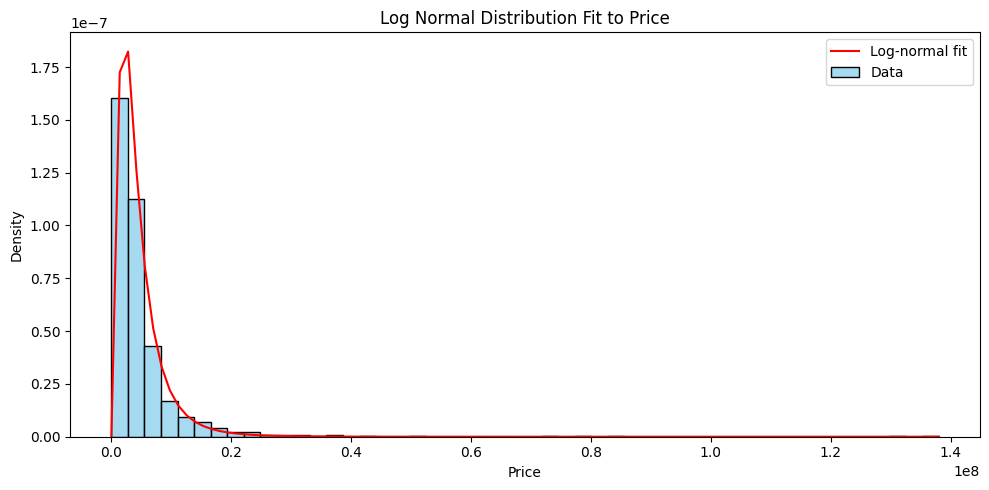

In [ ]:
y = data['price']
y = y[y > 0]

# Fit the log-normal distribution
shape, loc, scale = st.lognorm.fit(y, floc=0)

# Generate x values for the fitted curve
x = np.linspace(y.min(), y.max(), 100)

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(y, kde=False, stat="density", bins=50, color='skyblue', label="Data")
plt.plot(x, st.lognorm.pdf(x, shape, loc=loc, scale=scale), 'r-', label="Log-normal fit")
plt.title('Log Normal Distribution Fit to Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


As you can see, the sale prices are right skewed. This was expected as few people can afford very expensive houses.

Log Normal distribution provides the best fit for our right-skewed SalePrice data
Applying Log transformation normalization better preserves the data structure

This transformation will improve model performance, especially for properties with extreme prices

In [ ]:
# Detecting outliers using the IQR method
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify lower outliers
lower_outliers = data[data['price'] < lower_bound]
print(f"Number of lower outliers: {len(lower_outliers)}")
print(lower_outliers[['price'] + [col for col in data.columns if data[col].dtype != 'object']].head())

print("\n" + "="*60 + "\n")

# Identify upper outliers
upper_outliers = data[data['price'] > upper_bound]
print(f"Number of upper outliers: {len(upper_outliers)}")
print(upper_outliers[['price'] + [col for col in data.columns if data[col].dtype != 'object']].head())


Number of lower outliers: 0
Empty DataFrame
Columns: [price, price, room, livingRoom, bathRoom, floor, age, authorizedRealtor, furnished, netSqm, grossSqm, inHousingComplex]
Index: []


Number of upper outliers: 184
       price     price  room  livingRoom  bathRoom  floor   age  \
2   19500000  19500000     4           1         2      2  10.0   
6   21000000  21000000     6           1         6      2   5.0   
15  17500000  17500000     6           2         4      2   2.0   
16  15500000  15500000     3           1         2      3  16.0   
19  11300000  11300000     6           2         3      2  15.0   

    authorizedRealtor  furnished  netSqm  grossSqm  inHousingComplex  
2                True      False     200       250                 0  
6                True       True     300       920                 0  
15               True      False     250       320                 0  
16              False       True     220       250                 0  
19               True     

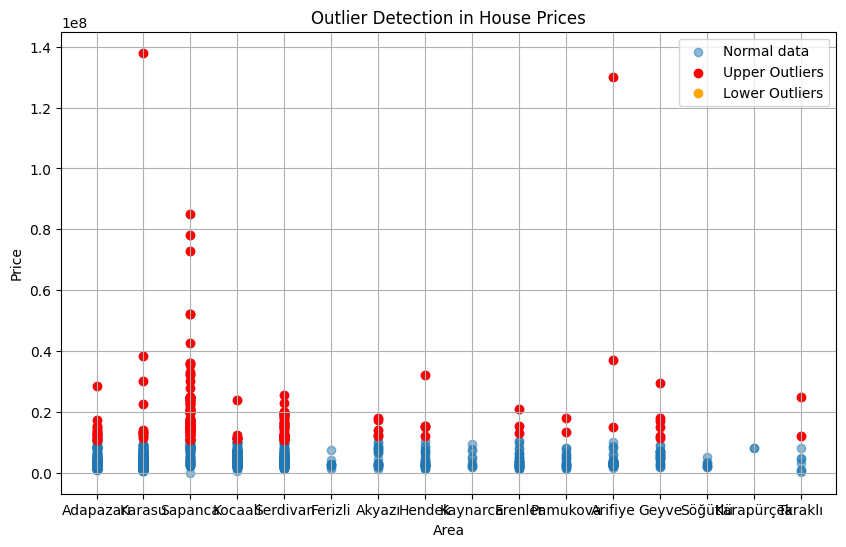

In [ ]:
data['county'] = data['county'].astype(str)

plt.figure(figsize=(10, 6))
plt.scatter(data['county'], data['price'], label='Normal data', alpha=0.5)

# Plot upper outliers
plt.scatter(upper_outliers['county'], upper_outliers['price'], color='red', label='Upper Outliers')

# Plot lower outliers
plt.scatter(lower_outliers['county'], lower_outliers['price'], color='orange', label='Lower Outliers')

plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Outlier Detection in House Prices')
plt.legend()
plt.grid(True)
plt.show()

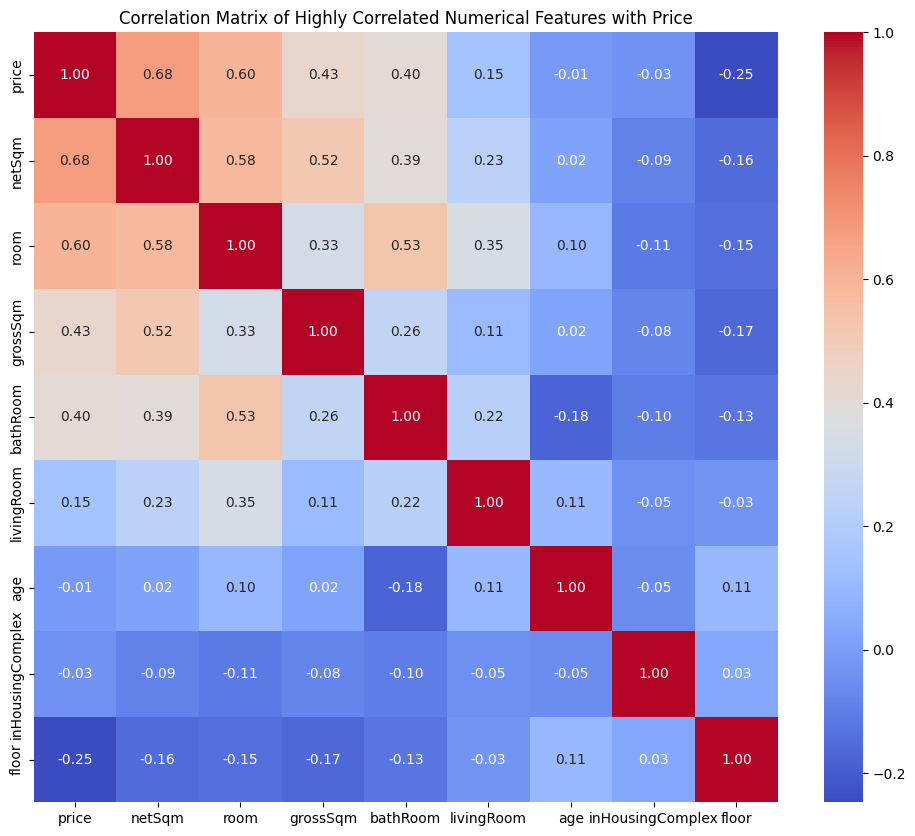

In [ ]:
numeric_cols = data.select_dtypes(include=np.number).columns
numeric_data = data[numeric_cols]

correlations = numeric_data.corr()

high_correlations = correlations['price'].sort_values(ascending=False)
high_corr_features = high_correlations.index
high_corr_matrix = correlations.loc[high_corr_features, high_corr_features]


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Highly Correlated Numerical Features with Price')
plt.show()


##**Collapse rare data**

In [ ]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = collapse_rare(data[col])


##**Handling Outliers**

Text(0, 0.5, 'Values')

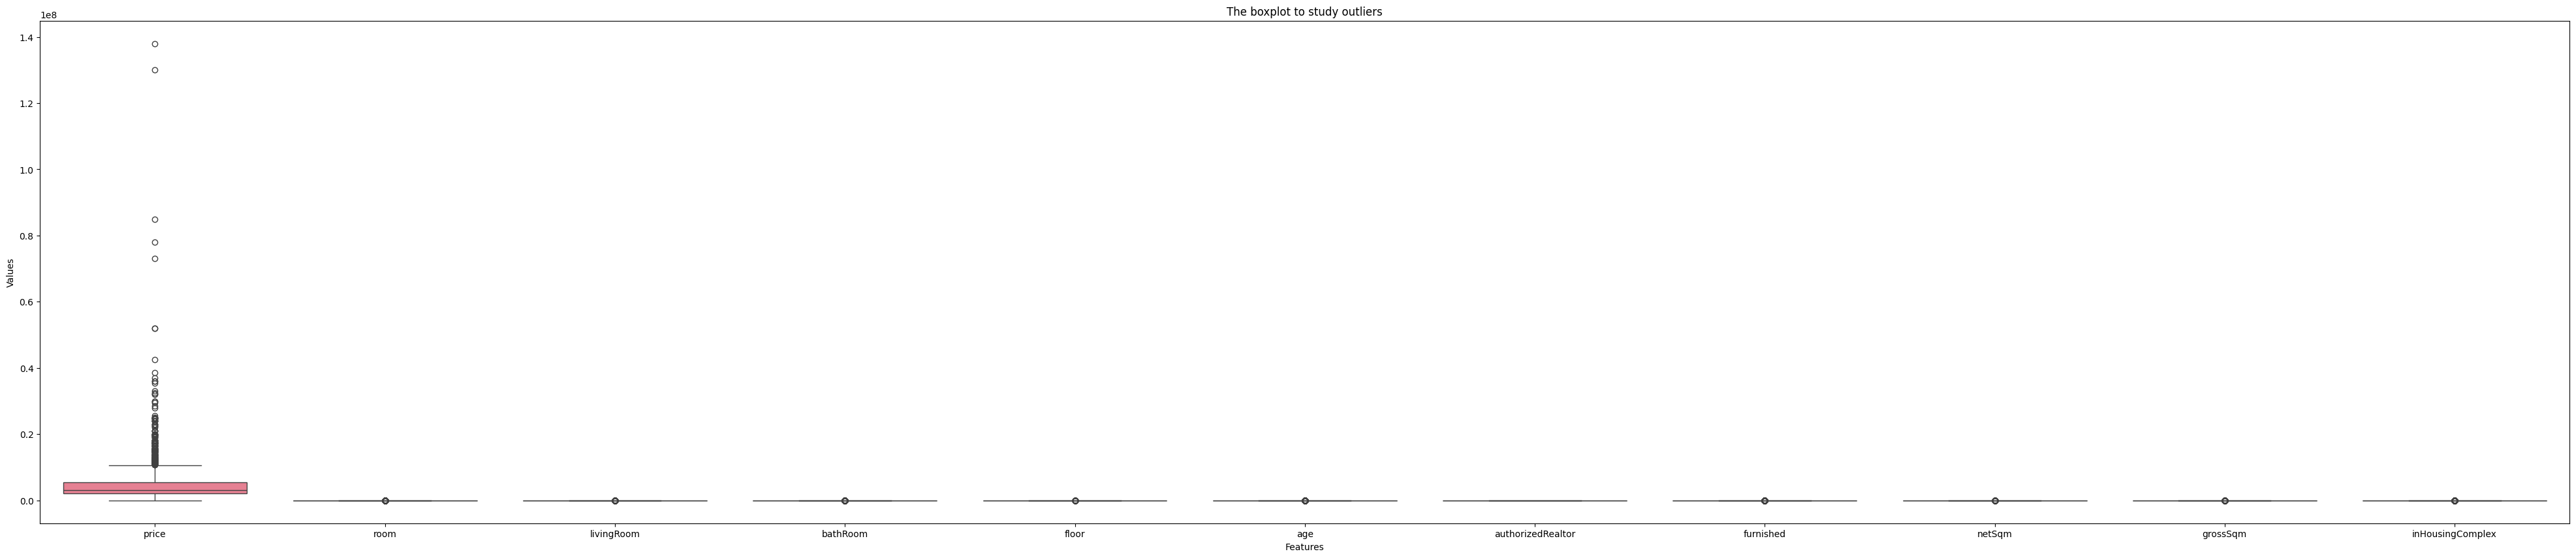

In [ ]:
plt.figure(figsize=(50,10))
sns.boxplot(data=data)
plt.title('The boxplot to study outliers')
plt.xlabel('Features')
plt.ylabel('Values')

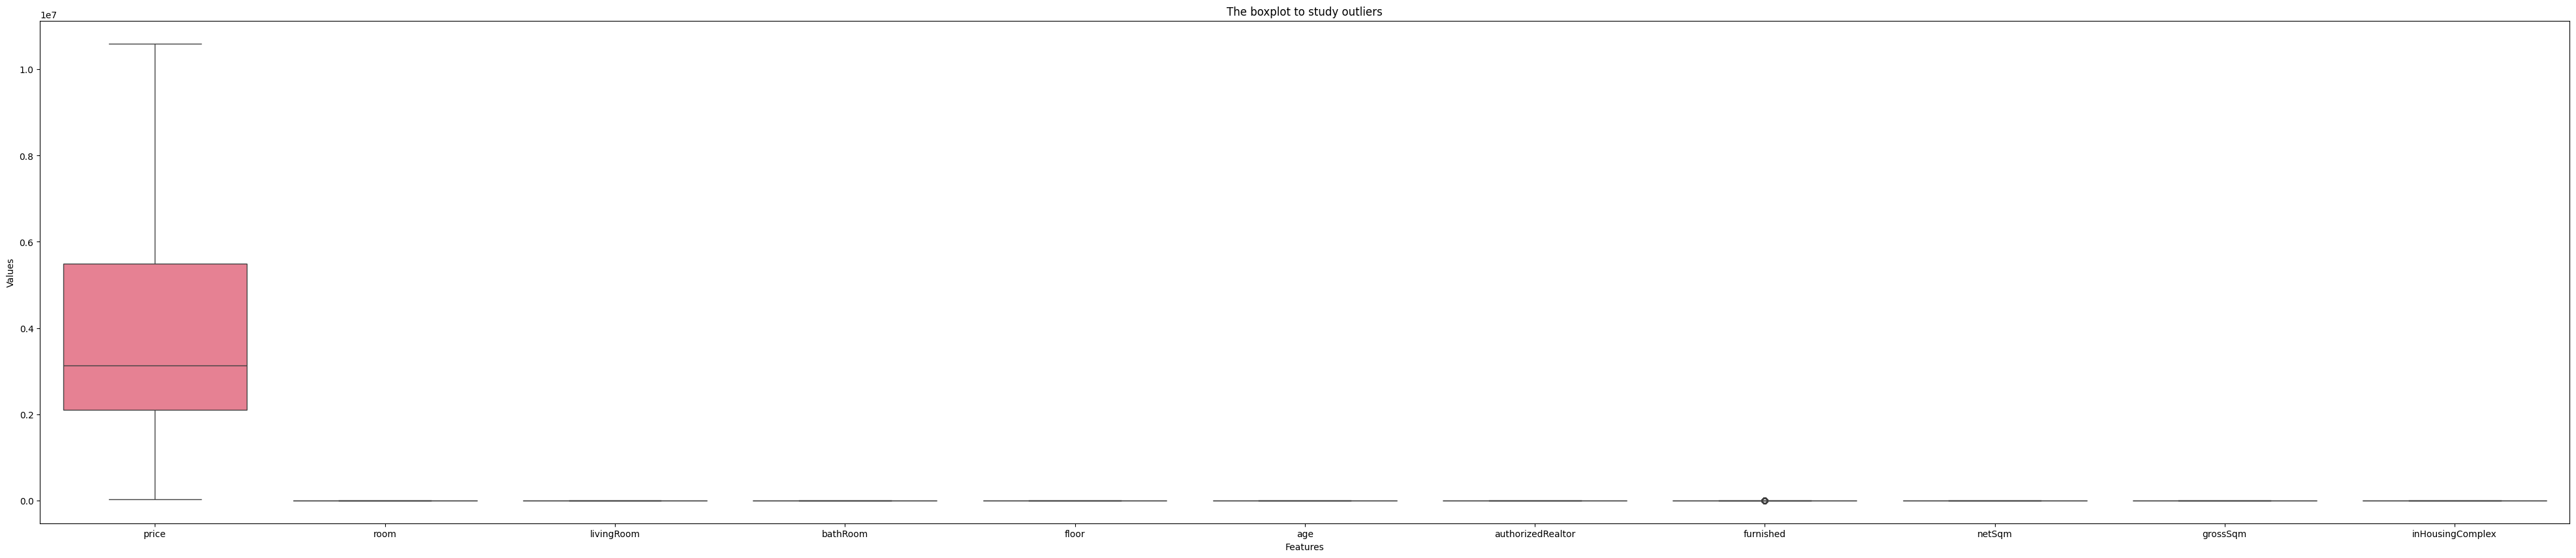

In [ ]:
for col in data.select_dtypes(include=np.number).columns:
    lr, ur = remove_outlier(data[col])
    data[col] = np.where(data[col] > ur, ur, data[col])
    data[col] = np.where(data[col] < lr, lr, data[col])


plt.figure(figsize=(50, 10))
sns.boxplot(data=data)
plt.title('The boxplot to study outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

## **Feature Engineering**

In [ ]:
# --- 2. Feature Engineering ------------------
data['area_efficiency'] = data['netSqm'] / data['grossSqm']
data['total_rooms'] = data['room'] + data['bathRoom']+data['livingRoom']
data['room_per_sqm'] = data['room'] / data['netSqm']
data["net_per_room"] = data["netSqm"] / (data["room"] + 1)
data['is_new'] = (data['age'] == 0.0).astype(int)



In [ ]:
columns_to_drop = ['residence', 'heating', 'build','inHousingComplex','livingRoom']

data = data.drop(columns=columns_to_drop)

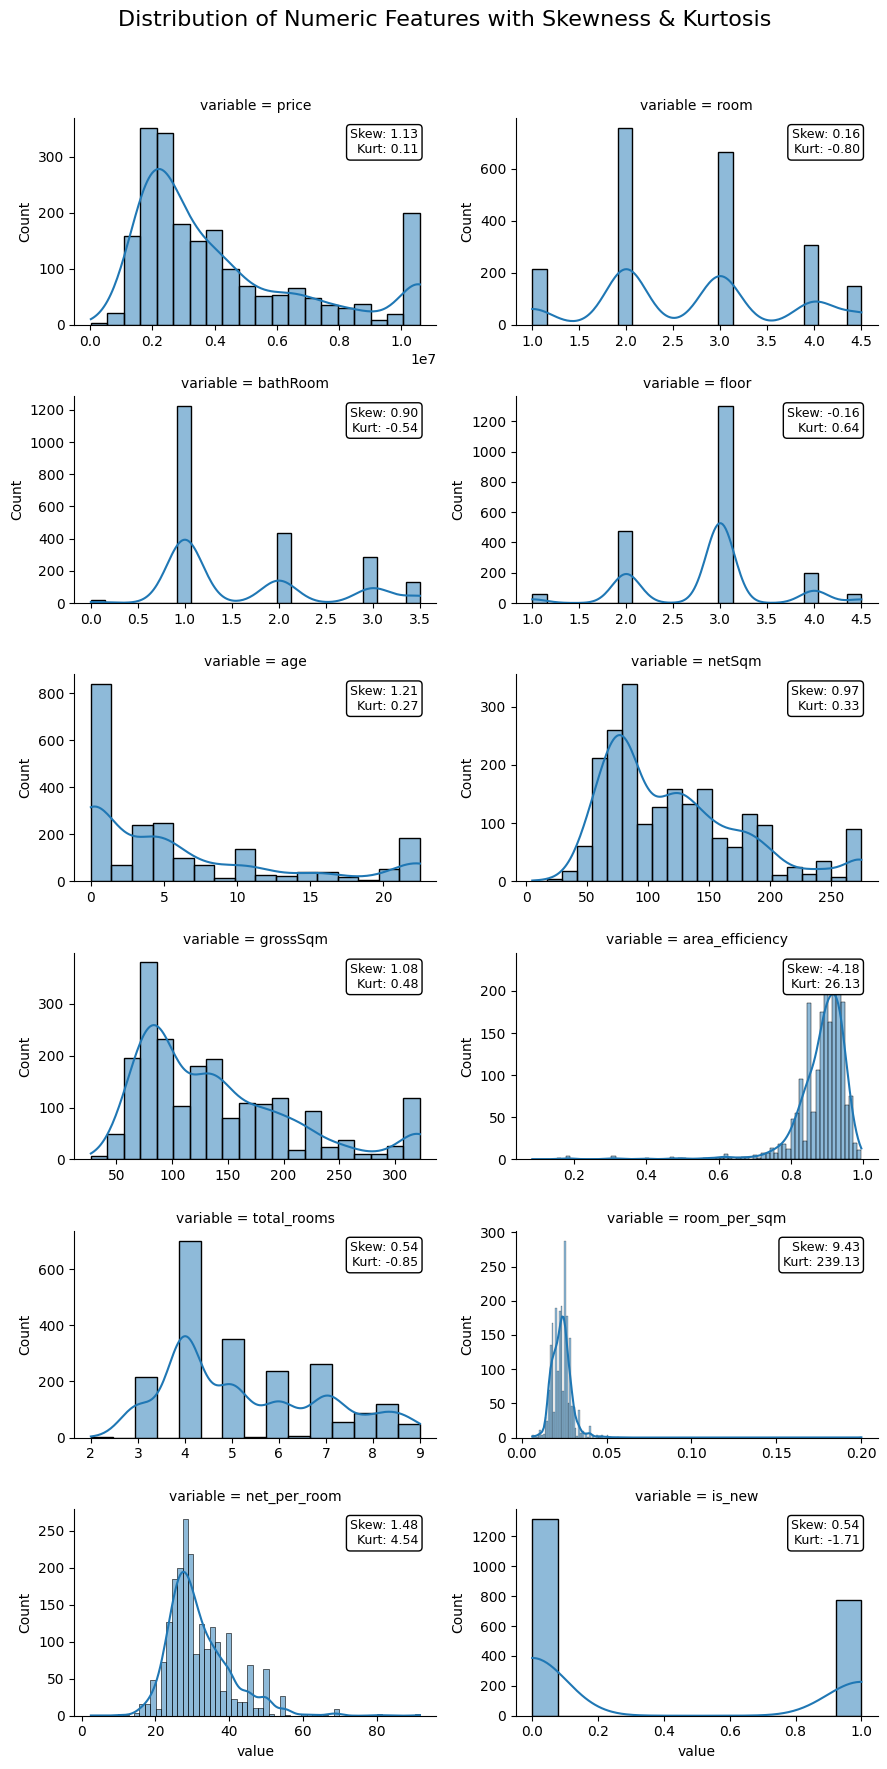


Distribution Summary:
                 Skewness     Skewness Description
price            1.132848      Highly right-skewed
room             0.163646       Fairly symmetrical
bathRoom         0.895940  Moderately right-skewed
floor           -0.163028       Fairly symmetrical
age              1.211979      Highly right-skewed
netSqm           0.969647  Moderately right-skewed
grossSqm         1.079702      Highly right-skewed
area_efficiency -4.178179       Highly left-skewed
total_rooms      0.543929  Moderately right-skewed
room_per_sqm     9.431713      Highly right-skewed
net_per_room     1.482402      Highly right-skewed
is_new           0.539944  Moderately right-skewed


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Select numeric features
quantitative = data.select_dtypes(include=[np.number]).columns.tolist()

# Calculate skewness and kurtosis
stats = pd.DataFrame({
    'Skewness': data[quantitative].apply(lambda x: skew(x.dropna())),
    'Kurtosis': data[quantitative].apply(lambda x: kurtosis(x.dropna()))
})

# Classify distributions
def interpret_skew(s):
    if s < -1:
        return "Highly left-skewed"
    elif s < -0.5:
        return "Moderately left-skewed"
    elif s < 0.5:
        return "Fairly symmetrical"
    elif s < 1:
        return "Moderately right-skewed"
    else:
        return "Highly right-skewed"

def interpret_kurtosis(k):
    if k < 3:
        return "Light-tailed (platykurtic)"
    elif k == 3:
        return "Normal-tailed (mesokurtic)"
    else:
        return "Heavy-tailed (leptokurtic)"

stats["Skewness Description"] = stats["Skewness"].apply(interpret_skew)
stats["Kurtosis Description"] = stats["Kurtosis"].apply(interpret_kurtosis)

# Melt data for seaborn plotting
f = pd.melt(data, value_vars=quantitative)

# Plot distribution with KDE
g = sns.FacetGrid(
    f,
    col="variable",
    col_wrap=2,
    sharex=False,
    sharey=False,
    height=3,
    aspect=1.5
)

g.map(sns.histplot, "value", kde=True)

# Annotate each subplot with skewness and kurtosis
for ax in g.axes.flatten():
    var = ax.get_title().split(" = ")[-1]
    if var in stats.index:
        skew_val = stats.loc[var, 'Skewness']
        kurt_val = stats.loc[var, 'Kurtosis']
        ax.text(
            0.95, 0.95,
            f"Skew: {skew_val:.2f}\nKurt: {kurt_val:.2f}",
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
        )

# Add overall title
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Distribution of Numeric Features with Skewness & Kurtosis', fontsize=16)

plt.show()

# Print distribution interpretation summary
print("\nDistribution Summary:")
print(stats[["Skewness", "Skewness Description"]])


**Highly right-skewed**: price, age, grossSqm, room_per_sqm, net_per_room

**Moderately right-skewed**: bathRoom, netSqm, total_rooms, is_new
**area_efficiency** is highly left-skewed

#**Linear Regressors models**

As the first leg of our modeling journey, we chose **Linear Regression** and **Lasso** for their unmatched clarity and interpretability. Here’s **how** we supercharged our data to get the best from these classics:

🔄 1. Taming Skewness with **Log‑Transforms**

Our superstar features—`price`, `netSqm`, and `grossSqm`—were **heavily right‑skewed**, meaning a few mega‑values could hijack the analysis. A quick `log(1 + x)` magic trick:

* **Stabilizes** variance across all listings
* **Linearizes** feature–target relationships
* **Preps** the ground for rock‑solid coefficient estimates

🎯 2. Leveling the Playing Field with **Min‑Max Scaling**

When features speak in wildly different scales, the loudest ones drown out the rest. Enter **MinMaxScaler**:

* Squashes every numeric column into the **\[0, 1]** range
* Ensures **fair contribution** from each predictor
* Speeds up solver **convergence** for a smoother fit

✨ Why Linear Regression & Lasso?

* **Linear Regression**:

  * **Crystal‑clear coefficients** (“+β units of log‑price per extra sqm”)
  * Perfect for **transparent insights** into feature impact

* **Lasso (L1 Regularization)**:

  * **Shrinks** weak features toward zero
  * **Slashes** overfitting, highlighting only the powerhouse predictors


In [ ]:
data1 = data.copy()

In [ ]:
data1 = transform_skewed_columns(data1)
quantitative = data1.select_dtypes(include=[np.number]).columns.tolist()
skew_summary = pd.DataFrame({
    'Feature': quantitative,
    'Original Skewness': skew(data[quantitative].dropna()),
    'Transformed Skewness': skew(data1[quantitative].dropna())
})

skew_summary

,Feature,Original Skewness,Transformed Skewness
0,price,1.132848,-0.028208
1,room,0.163646,0.163646
2,bathRoom,0.895940,0.895940
3,floor,-0.163028,-0.163028
4,age,1.211979,0.081672
5,netSqm,0.969647,0.969647
6,grossSqm,1.079702,0.225369
7,area_efficiency,-4.178179,3.620199
8,total_rooms,0.543929,0.543929
9,room_per_sqm,9.431713,8.119090


In [ ]:
numerical_cols = data1.select_dtypes(include=np.number).columns.tolist()

numerical_features_to_scale = [col for col in numerical_cols if col != 'price']

scaler = MinMaxScaler()

data1[numerical_features_to_scale] = scaler.fit_transform(data1[numerical_features_to_scale])

## **1.Linear Regression**

In [ ]:
encoded_df3 = data1.copy()


Test R² Score: 0.7616
Training R² Score: 0.7884
CV R²: 0.7581
Linear Regression Model Performance on Test Set:
R² Score : 0.7727
MAE      : 890,239.63 TL
RMSE     : 1,358,815.58 TL
MAPE     : 25.13%


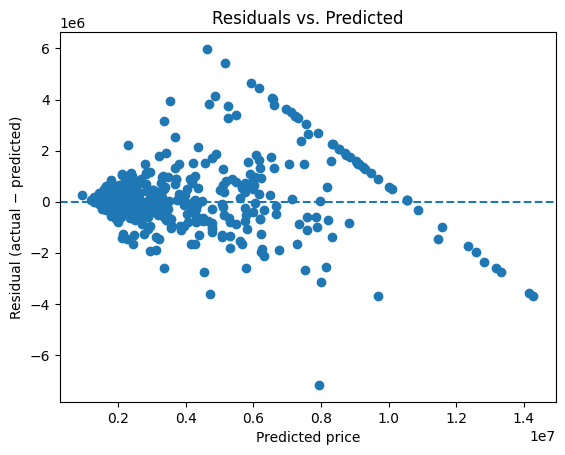


✅ Linear model saved as 'linear_regression_pipeline_model.pkl'


In [ ]:
# Bağımlı ve bağımsız değişkenleri ayır
X = encoded_df3.drop(columns=['price'])
y = encoded_df3['price']

# Eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sayısal ve kategorik sütunları otomatik algıla
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Ön işleme adımları
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features)
])

# Pipeline oluştur ve modeli eğit
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)

# Tahmin ve değerlendirme
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\nTest R² Score: {r2:.4f}")

train_pred = pipeline.predict(X_train)
train_r2 = r2_score(y_train, train_pred)
print(f"Training R² Score: {train_r2:.4f}")


train_cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
pipeline.fit(X_train, y_train)
final_test_score = r2_score(y_test, pipeline.predict(X_test))

print(f"CV R²: {train_cv_scores.mean():.4f}")

y_pred_log = pipeline.predict(X_test)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

# Evaluate on Test set
lr_r2   = r2_score(y_test_real, y_pred_real)
lr_mae  = mean_absolute_error(y_test_real, y_pred_real)
lr_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
lr_mape = mean_absolute_percentage_error(y_test_real, y_pred_real) * 100

print("Linear Regression Model Performance on Test Set:")
print(f"R² Score : {lr_r2:.4f}")
print(f"MAE      : {lr_mae:,.2f} TL")
print(f"RMSE     : {lr_rmse:,.2f} TL")
print(f"MAPE     : {lr_mape:.2f}%")

y_test_pred = pipeline.predict(X_test)
residuals = np.expm1(y_test) - np.expm1(y_test_pred)

plt.scatter(np.expm1(y_test_pred), residuals)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted price")
plt.ylabel("Residual (actual − predicted)")
plt.title("Residuals vs. Predicted")
plt.show()

# Save the final pipeline
joblib.dump(pipeline, 'linear_regression_pipeline_model.pkl')
print("\n✅ Linear model saved as 'linear_regression_pipeline_model.pkl'")

## **2.Lasso Regression**

In [ ]:
encoded_df5 = data1.copy()

🎯 Lasso (Log + Feature Engineering + Selection) Model Performansı:
Best Alpha: 0.01
MAE: 888,894.22 TL
RMSE: 1,308,586.29 TL
R² Score: 0.7724
MAPE     : 24.35%


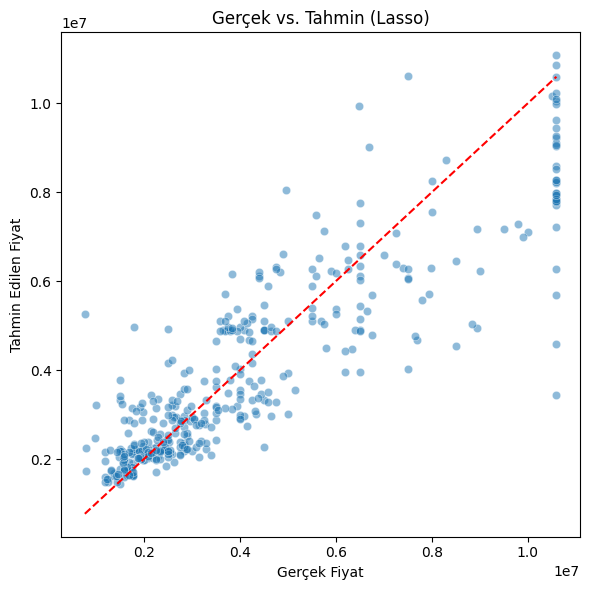


✅ Lasso model saved as 'lasso_pipeline_model.pkl'


In [ ]:
# 1. Split X and y
X = encoded_df5.drop(columns=["price"])
y = encoded_df5["price"]

# 2. Split into Train / Validation / Test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Preprocessing setup
categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# 4. Lasso pipeline
lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_regression, k=50)),
    ("regressor", Lasso(max_iter=10000))
])

param_grid = {"regressor__alpha": np.logspace(-2, 3, 20)}
lasso_grid = GridSearchCV(
    lasso_pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error"
)
lasso_grid.fit(X_train, y_train)

best_alpha = lasso_grid.best_params_["regressor__alpha"]

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_regression, k=50)),
    ("regressor", Lasso(alpha=best_alpha, max_iter=10000))
])
final_pipeline.fit(X_train_val, y_train_val)

# 7. Final evaluation on Test set
y_pred_log = final_pipeline.predict(X_test)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

# Metrics
lasso_mae = mean_absolute_error(y_test_real, y_pred_real)
lasso_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
lasso_r2 = r2_score(y_test_real, y_pred_real)
lasso_mape = mean_absolute_percentage_error(y_test_real, y_pred_real) * 100


print("🎯 Lasso (Log + Feature Engineering + Selection) Model Performansı:")
print(f"Best Alpha: {best_alpha}")
print(f"MAE: {lasso_mae:,.2f} TL")
print(f"RMSE: {lasso_rmse:,.2f} TL")
print(f"R² Score: {lasso_r2:.4f}")
print(f"MAPE     : {lasso_mape:.2f}%")


# --- Gerçek vs. Tahmin ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_real, y=y_pred_real, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], '--', color='red')
plt.xlabel("Gerçek Fiyat")
plt.ylabel("Tahmin Edilen Fiyat")
plt.title("Gerçek vs. Tahmin (Lasso)")
plt.tight_layout()
plt.show()

# Save the final pipeline
joblib.dump(final_pipeline, 'lasso_pipeline_model.pkl')
print("\n✅ Lasso model saved as 'lasso_pipeline_model.pkl'")


# **Tree-based models🌳**

Given our dataset’s pronounced **right‑skew** and **heavy‑tailed** distributions—even in the target variable (`price`)—we pivot to tree‑based algorithms for the next phase. Here’s why they’re a perfect fit:

1. **Distribution‑Agnostic & Outlier‑Resilient**

   * Unlike linear regressors, **Decision Trees**, **Random Forests**, and **XGBoost** make **no assumptions** about normality.
   * They handle skewness and extreme values naturally, letting us preserve the full information in features like `netSqm`, `grossSqm`, and `price` without forced transformations.

2. **Built‑In Nonlinear & Interaction Modeling**

   * Tree splits automatically capture **nonlinear dependencies** (e.g., the way `area` impacts `price` may shift with `age` or `floor`).
   * No need to manually craft polynomial terms or interaction features—trees discover them organically during training.

3. **Ensemble Power for Robustness & Generalization**

   * **Random Forest** and **XGBoost** aggregate hundreds (or thousands) of individual trees, dramatically reducing overfitting.
   * They deliver **feature‑importance insights** out of the box, spotlighting which predictors drive price variation most strongly.



## **1.Decision Tree**

In [ ]:
encoded_df = data.copy()

In [ ]:
def encode_features(df, low_card_cols=None):

    data_encoded = data.copy()

    if low_card_cols is None:
        low_card_cols = [
            'heating_grouped', 'build_grouped', 'buildState', 'credit',
            'barter', 'landRegisterName', 'subCategory', 'fuel','furnished',
            'residence_grouped','usage','sides'
        ]

    # 1) Frequency encode
    for col in ['areas', 'district', 'county']:
        data_encoded[col] = data_encoded[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
        freq = data_encoded[col].value_counts(normalize=True)
        data_encoded[f'{col}_freq'] = data_encoded[col].map(freq)

    # 2) One-hot encode low-cardinality features
    data_encoded = pd.get_dummies(
        data_encoded,
        columns=[c for c in low_card_cols if c in data_encoded],
        drop_first=False
    )
    return data_encoded

In [ ]:
encoded_df = encode_features(encoded_df)

for c in ["netSqm", "grossSqm","price"]:
    encoded_df[c] = np.log1p(encoded_df[c])

columns_to_drop = [
    'areas','district', 'county'
]
encoded_df = encoded_df.drop(columns=columns_to_drop)

Shapes — train: (1254, 55) val: (418, 55) test: (419, 55)
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Best params: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 50}
Best CV MSE: 0.12011973068050448

Final Test Metrics:
MAE  : 785,428 TL
MSE  : 1,466,222,903,112
RMSE : 1,210,877 TL
R²   : 0.8051
MAPE : 22.7%


<Figure size 1000x800 with 0 Axes>

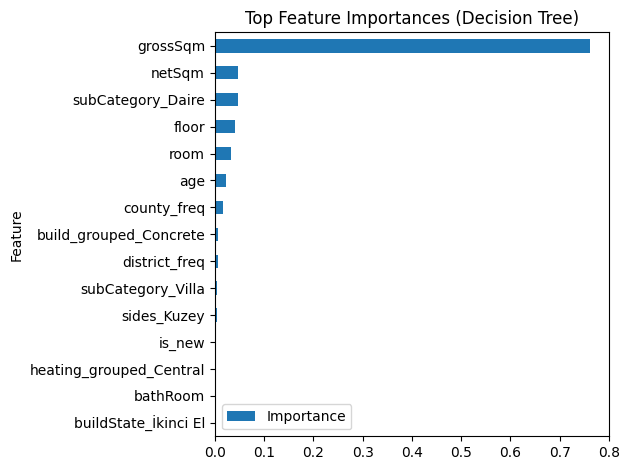

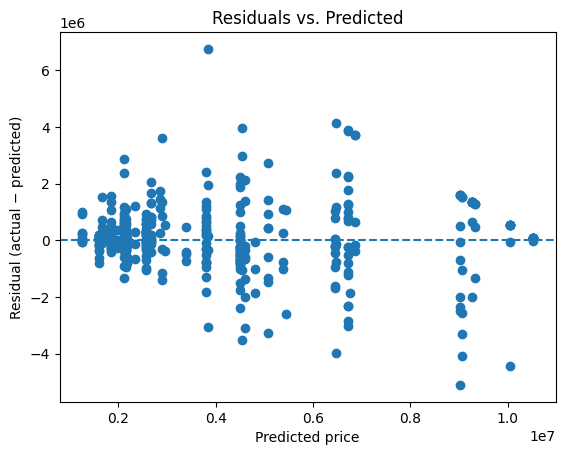


Model saved as 'decision_tree_model.pkl'


In [ ]:
# --- 1. Prepare Features and Target -----------------------
y = encoded_df["price"]
X = encoded_df.drop("price", axis=1)

# --- 2) Split 60% train, 20% val, 20% test -------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.6, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Shapes — train:", X_train.shape,
      "val:",   X_val.shape,
      "test:",  X_test.shape)

# --- 3) Hyperparameter search on the 60% train --------
param_grid = {
    "max_depth":  [1,2, 3, 4, 6, 8 ,None],
    "min_samples_split": [2,10, 30, 50, 80],
    "min_samples_leaf": [1, 5, 10, 15, 20]
}

grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV MSE:", -grid.best_score_)


# --- 4) Retrain on Train+Val (80%) using best params --
best_dt = DecisionTreeRegressor(random_state=42, **grid.best_params_)

X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)


best_dt.fit(X_train_val, y_train_val)

# --- 5) Final evaluation on the 20% test ---------------
y_test_log_pred = best_dt.predict(X_test)

# 1) Back-transform to original scale
y_test_pred = np.expm1(y_test_log_pred)
y_test_true = np.expm1(y_test)

dt_mae = mean_absolute_error(y_test_true, y_test_pred)
dt_mse = mean_squared_error(y_test_true, y_test_pred)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test_true, y_test_pred)
dt_mape = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100

print("\nFinal Test Metrics:")
print(f"MAE  : {dt_mae:,.0f} TL")
print(f"MSE  : {dt_mse:,.0f}")
print(f"RMSE : {dt_rmse:,.0f} TL")
print(f"R²   : {dt_r2:.4f}")
print(f"MAPE : {dt_mape:.1f}%")

# --- 6. Feature Importance Plot ----------------------------
if hasattr(best_dt, 'feature_importances_'):
    importances = best_dt.feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=True)

    top_n = min(15, len(importance_df))
    plt.figure(figsize=(10, 8))
    importance_df.tail(top_n).plot(kind='barh', x='Feature', y='Importance')
    plt.title('Top Feature Importances (Decision Tree)')
    plt.tight_layout()
    plt.show()

y_test_pred = best_dt.predict(X_test)
residuals = np.expm1(y_test) - np.expm1(y_test_pred)

plt.scatter(np.expm1(y_test_pred), residuals)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted price")
plt.ylabel("Residual (actual − predicted)")
plt.title("Residuals vs. Predicted")
plt.show()

# --- 7. Save the Model -------------------------------------
joblib.dump(best_dt, "decision_tree_model.pkl")
print("\nModel saved as 'decision_tree_model.pkl'")


In [ ]:
'''from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Create a fresh model with best hyperparameters
model = DecisionTreeRegressor(random_state=42, **grid.best_params_)

# Compute learning curves (use training+validation set)
train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train_val,
    y_train_val,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Convert negative MSE to RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, 'o-', label="Training RMSE")
plt.plot(train_sizes, val_rmse, 'o-', label="Validation RMSE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve (Decision Tree)")
plt.legend()
plt.grid(True)
plt.show()
'''

'from sklearn.model_selection import learning_curve\nimport matplotlib.pyplot as plt\n\n# Create a fresh model with best hyperparameters\nmodel = DecisionTreeRegressor(random_state=42, **grid.best_params_)\n\n# Compute learning curves (use training+validation set)\ntrain_sizes, train_scores, val_scores = learning_curve(\n    model,\n    X_train_val,\n    y_train_val,\n    train_sizes=np.linspace(0.1, 1.0, 10),\n    cv=5,\n    scoring="neg_mean_squared_error",\n    n_jobs=-1\n)\n\n# Convert negative MSE to RMSE\ntrain_rmse = np.sqrt(-train_scores.mean(axis=1))\nval_rmse = np.sqrt(-val_scores.mean(axis=1))\n\n# Plot learning curve\nplt.figure(figsize=(10, 6))\nplt.plot(train_sizes, train_rmse, \'o-\', label="Training RMSE")\nplt.plot(train_sizes, val_rmse, \'o-\', label="Validation RMSE")\nplt.xlabel("Training Set Size")\nplt.ylabel("RMSE")\nplt.title("Learning Curve (Decision Tree)")\nplt.legend()\nplt.grid(True)\nplt.show()\n'

## **2.XGBoost**

In [ ]:
encoded_df4 = data.copy()

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best CV MAE: 778,468 TL

Model Performance Metrics on Test Set:
MAE: 674,207 TL
R² Score: 0.8633
RMSE: 1,014,235 TL
MAPE: 19.5%


<Figure size 1000x800 with 0 Axes>

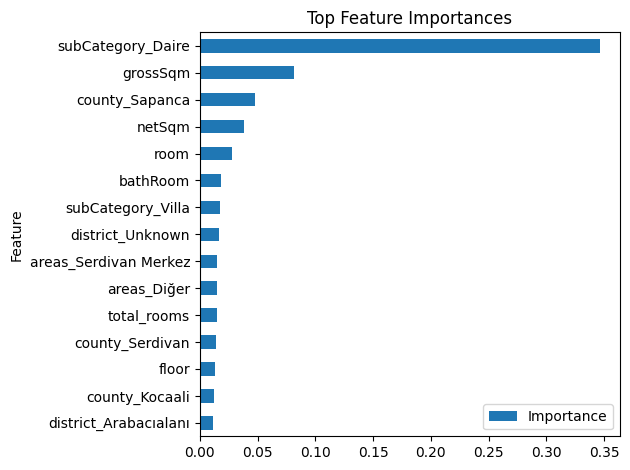

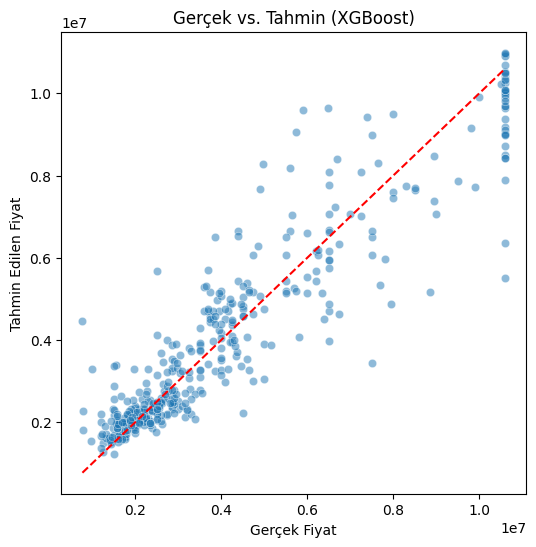


Model saved as 'xgboost_pipeline_model.pkl'


In [ ]:
y = encoded_df4["price"]
X = encoded_df4.drop(columns=["price"])

for col in X.select_dtypes(include=["object", "bool"]).columns:
    X[col] = X[col].astype(str)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.6, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# --- Model Pipeline ---
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(
        random_state=42,
        verbosity=0,
        use_label_encoder=False
    ))
])

param_grid = {
    'regressor__n_estimators': [50,100,200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree':  [0.6, 0.8, 1.0],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__gamma': [0]
}


search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

print(f"\nBest CV MAE: {-search.best_score_:,.0f} TL")

best_model = search.best_estimator_

X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_train_val, y_train_val)
y_pred = best_model.predict(X_test)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

xg_mae = mean_absolute_error(y_test, y_pred)
xg_r2 = r2_score(y_test, y_pred)
xg_rmse = root_mean_squared_error(y_test, y_pred)
xg_mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nModel Performance Metrics on Test Set:")
print(f"MAE: {xg_mae:,.0f} TL")
print(f"R² Score: {xg_r2:.4f}")
print(f"RMSE: {xg_rmse:,.0f} TL")
print(f"MAPE: {xg_mape:.1f}%")

# --- Feature Importance Plot ---
if hasattr(best_model['regressor'], 'feature_importances_'):
    preprocessor = best_model['preprocessor']

    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = (
        ohe.get_feature_names_out(categorical_cols).tolist()
        if hasattr(ohe, 'get_feature_names_out') else []
    )

    feature_names = numerical_cols + cat_feature_names
    importances = best_model['regressor'].feature_importances_

    if len(importances) == len(feature_names):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=True)

        plt.figure(figsize=(10, 8))
        top_n = min(15, len(importance_df))
        importance_df.tail(top_n).plot(kind='barh', x='Feature', y='Importance')
        plt.title('Top Feature Importances')
        plt.tight_layout()
        plt.show()

# --- Gerçek vs. Tahmin ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Gerçek Fiyat")
plt.ylabel("Tahmin Edilen Fiyat")
plt.title("Gerçek vs. Tahmin (XGBoost)")
plt.show()

# --- Save Model ---
joblib.dump(best_model, 'xgboost_pipeline_model.pkl')
print("\nModel saved as 'xgboost_pipeline_model.pkl'")


In [ ]:
'''
best_params = search.best_estimator_
train_sizes, train_scores, val_scores = learning_curve(
    best_params,
    X_train_val,
    y_train_val,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Convert negative MSE to RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, 'o-', label="Training RMSE")
plt.plot(train_sizes, val_rmse, 'o-', label="Validation RMSE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve (XgBoost Tree)")
plt.legend()
plt.grid(True)
plt.show()
'''

'\nbest_params = search.best_estimator_\ntrain_sizes, train_scores, val_scores = learning_curve(\n    best_params,\n    X_train_val,\n    y_train_val,\n    train_sizes=np.linspace(0.1, 1.0, 10),\n    cv=5,\n    scoring="neg_mean_squared_error",\n    n_jobs=-1\n)\n\n# Convert negative MSE to RMSE\ntrain_rmse = np.sqrt(-train_scores.mean(axis=1))\nval_rmse = np.sqrt(-val_scores.mean(axis=1))\n\n# Plot learning curve\nplt.figure(figsize=(10, 6))\nplt.plot(train_sizes, train_rmse, \'o-\', label="Training RMSE")\nplt.plot(train_sizes, val_rmse, \'o-\', label="Validation RMSE")\nplt.xlabel("Training Set Size")\nplt.ylabel("RMSE")\nplt.title("Learning Curve (XgBoost Tree)")\nplt.legend()\nplt.grid(True)\nplt.show()\n'

## **3.Random Forest**

In [ ]:
encoded_df2 = data.copy()

In [ ]:
low_card_cols = [
            'heating_grouped', 'build_grouped', 'buildState', 'credit',
            'barter', 'landRegisterName', 'subCategory', 'fuel','furnished',
            'residence_grouped','usage','sides'
        ]
low_card_cols = [col for col in low_card_cols if col in encoded_df2.columns]
print("Columns used for one-hot encoding:", low_card_cols)

# Perform one-hot encoding
encoded_df2 = pd.get_dummies(encoded_df2, columns=low_card_cols, drop_first=True)

encoded_df2['areas'] = encoded_df2['areas'].astype(str)
encoded_df2['district'] = encoded_df2['district'].astype(str)
encoded_df2['county'] = encoded_df2['county'].astype(str)

encoded_df2['areas_freq'] = encoded_df2['areas'].map(encoded_df2['areas'].value_counts(normalize=True))
encoded_df2['district_freq'] = encoded_df2['district'].map(encoded_df2['district'].value_counts(normalize=True))
encoded_df2['county_freq'] = encoded_df2['county'].map(encoded_df2['county'].value_counts(normalize=True))


encoded_df2 = encoded_df2.drop(columns=['areas', 'district', 'county'])

Columns used for one-hot encoding: ['heating_grouped', 'build_grouped', 'buildState', 'credit', 'barter', 'landRegisterName', 'subCategory', 'fuel', 'furnished', 'residence_grouped', 'usage', 'sides']


Fitting 5 folds for each of 24 candidates, totalling 120 fits

Final Test Metrics:
MAE  : 698,373 TL
MSE  : 1,146,211,023,687
RMSE : 1,070,612 TL
R²   : 0.8476
MAPE : 20.8%


<Figure size 1000x800 with 0 Axes>

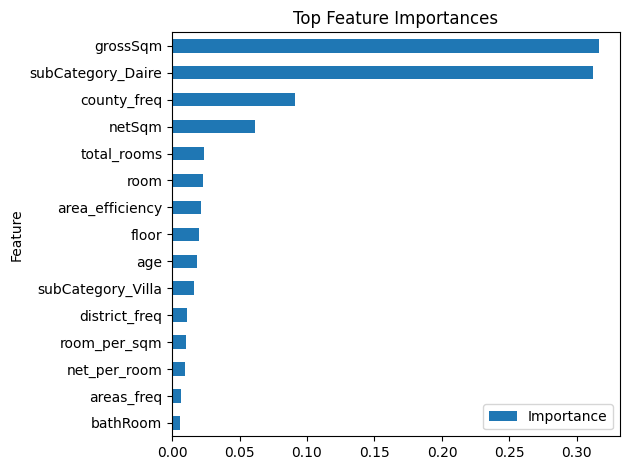


Model saved as 'random_forest_model.pkl'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# --- 1. Data Preparation ---
y = encoded_df2['price']
X = encoded_df2.drop(['price'], axis=1)

# --- 2. Train/Validation/Test Split ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Combine training and validation sets for cross-validation training
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

# --- 3. Hyperparameter Grid ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# --- 4. Grid Search with Cross-Validation ---
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_cv, y_cv)

# --- 5. Final Model Evaluation ---
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_test_pred)
rf_mse = mean_squared_error(y_test, y_test_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_test_pred)
rf_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print("\nFinal Test Metrics:")
print(f"MAE  : {rf_mae:,.0f} TL")
print(f"MSE  : {rf_mse:,.0f}")
print(f"RMSE : {rf_rmse:,.0f} TL")
print(f"R²   : {rf_r2:.4f}")
print(f"MAPE : {rf_mape:.1f}%")

# --- 6. Feature Importance Plot ---
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=True)

    top_n = min(15, len(importance_df))
    plt.figure(figsize=(10, 8))
    importance_df.tail(top_n).plot(kind='barh', x='Feature', y='Importance')
    plt.title('Top Feature Importances')
    plt.tight_layout()
    plt.show()


joblib.dump(best_model, 'random_forest_model.pkl')
print("\nModel saved as 'random_forest_model.pkl'")


# **Comparison of the Perfomances**

In [ ]:
results = {
    'Model': ['LinearRegression', 'Lasso', 'RandomForest', 'XGBoost','Decision Tree'],
    'MAE':   [lr_mae,  lasso_mae,   rf_mae,  xg_mae,  dt_mae],
    'RMSE':  [lr_rmse,  lasso_rmse,  rf_rmse,  xg_rmse,  dt_rmse],
    'MAPE':  [lr_mape,  lasso_mape,  rf_mape,  xg_mape,  dt_mape],
    'R2':    [lr_r2,    lasso_r2,    rf_r2,  xg_r2,  dt_r2],
}

metrics_df = pd.DataFrame(results).set_index('Model')
print(metrics_df)

                            MAE          RMSE       MAPE        R2
Model                                                             
LinearRegression  890239.629434  1.358816e+06  25.132490  0.772661
Lasso             888894.218778  1.308586e+06  24.345351  0.772371
RandomForest      698373.015040  1.070612e+06  20.810023  0.847634
XGBoost           674206.844272  1.014235e+06  19.520561  0.863259
Decision Tree     785427.649588  1.210877e+06  22.672185  0.805095


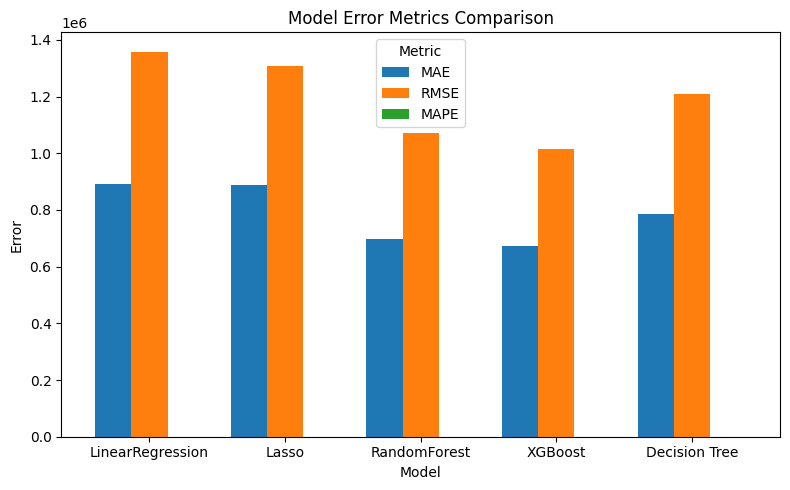

In [ ]:
import matplotlib.pyplot as plt

error_metrics = ['MAE','RMSE','MAPE']

ax = metrics_df[error_metrics].plot(
    kind='bar',
    figsize=(8,5),
    rot=0,
    width=0.8
)

ax.set_title("Model Error Metrics Comparison")
ax.set_ylabel("Error")
ax.legend(title="Metric")
plt.tight_layout()
plt.show()


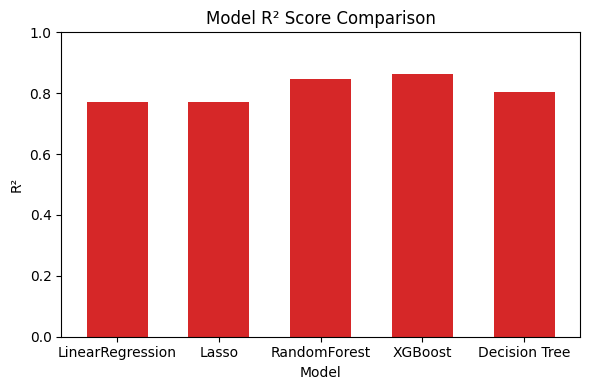

In [ ]:
plt.figure(figsize=(6,4))
metrics_df['R2'].plot(
    kind='bar',
    rot=0,
    width=0.6,
    color='C3'
)
plt.title("Model R² Score Comparison")
plt.ylabel("R²")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


# **New Data Entry and Prediction:**

In [ ]:
new_house = pd.DataFrame({
    'areas': ['Serdivan Merkez'],
    'district': ['İstiklal'],
    'county': ['Serdivan'],
    'room': [3],
    'livingRoom': [1],
    'bathRoom': [2],
    'floor': [5],
    'age': [3],
    'heating': ['Kombi'],
    'build': ['Betonarme'],
    'buildState': ['İkinci El'],
    'usage': ['Boş'],
    'credit': ['Uygun'],
    'barter': ['Yapilir'],
    'landRegisterName': ['Kat Mülkiyeti'],
    'authorizedRealtor': [True],
    'furnished': [1],
    'subCategory': ['Villa'],
    'netSqm': [100],
    'grossSqm': [200],
    'sides' : ['Kuzey'],
    'fuel': ['Doğalgaz'],
    'residence': ['Daire'],
    'has_video_tour': [1]
})
new_house['residence_grouped'] = new_house['residence'].apply(map_residence_type)
new_house['heating_grouped'] = new_house['heating'].apply(map_heating_group)
new_house['build_grouped'] = new_house['build'].apply(map_build_type)
new_house['area_efficiency'] = new_house['netSqm'] / new_house['grossSqm']
new_house['total_rooms'] = new_house['room'] + new_house['bathRoom']+new_house['livingRoom']
new_house['room_per_sqm'] = new_house['room'] / new_house['netSqm']
new_house["net_per_room"] = new_house["netSqm"] / (new_house["room"] + 1)
new_house['is_new'] = (new_house['age'] == 0.0).astype(int)

In [ ]:
#Decision Tree
best_dt = joblib.load("decision_tree_model.pkl")
new_house_processed = encode_features(new_house)
if 'price' in new_house_processed.columns:
    new_house_processed = new_house_processed.drop(columns=["price"])

new_house_processed = new_house_processed.drop(columns=[ "areas", "district", "county"])
predicted_df_price = np.expm1(best_dt.predict(new_house_processed))

In [ ]:
#Random Forest
rf_model = joblib.load("random_forest_model.pkl")
new_house2 = new_house.copy()
low_card_cols = [
    'heating_grouped', 'build_grouped', 'buildState', 'credit',
    'barter', 'landRegisterName', 'subCategory', 'fuel', 'furnished',
    'residence_grouped', 'usage', 'sides'
]

new_house2['areas'] = new_house2['areas'].astype(str)
new_house2['district'] = new_house2['district'].astype(str)
new_house2['county'] = new_house2['county'].astype(str)

new_house2 = pd.get_dummies(new_house2, columns=low_card_cols, drop_first=True)

new_house2['areas_freq'] = new_house2['areas'].map(data['areas'].value_counts(normalize=True))
new_house2['district_freq'] = new_house2['district'].map(data['district'].value_counts(normalize=True))
new_house2['county_freq'] = new_house2['county'].map(data['county'].value_counts(normalize=True))

new_house2.drop(columns=['areas', 'district', 'county', 'heating', 'build', 'residence'], inplace=True, errors='ignore')

new_house2 = new_house2.reindex(columns=rf_model.feature_names_in_, fill_value=0)

predicted_rf_price = rf_model.predict(new_house2)[0]

In [ ]:
# Lasso
new_house1 = new_house.copy()

numerical_cols = new_house1.select_dtypes(include=np.number).columns.tolist()

numerical_features_to_scale = [col for col in numerical_cols if col != 'price']

scaler = MinMaxScaler()

new_house1[numerical_features_to_scale] = scaler.fit_transform(new_house1[numerical_features_to_scale])

lasso_model = joblib.load('lasso_pipeline_model.pkl')
predicted_log_price = lasso_model.predict(new_house1)
predicted_price_lasso = np.expm1(predicted_log_price)


In [ ]:
#Linear Regression
lr_model = joblib.load('linear_regression_pipeline_model.pkl')
predicted_log_price = lr_model.predict(new_house1)
predicted_price_lr = np.expm1(predicted_log_price)

In [ ]:
# XGBoost Prediction
price_xgb = predict_with_xgboost_pipeline(new_house)
print("\n🌲 XGBoost Model Prediction")
print("=" * 30)
print(f"Predicted Price: {price_xgb:,.2f} TL")


# Random Forest
print("\n🌲 Random Forest Model Prediction")
print("=" * 34)
print(f"Predicted Price: {predicted_rf_price:,.2f} TL")


# Decision Tree
print("\n🌲 Decision Tree Model Prediction")
print("=" * 34)
print(f"Predicted Price: {predicted_df_price[0]:,.2f} TL")


# Lasso Prediction
print("\n🧲 Lasso Model Prediction")
print("=" * 30)
print(f"Predicted Price: {predicted_price_lasso[0]:,.2f} TL")

# Linear Regression Prediction
print("\n🧲 Linear regression Model Prediction")
print("=" * 34)
print(f"Predicted Price: {predicted_price_lr[0]:,.2f} TL")


🌲 XGBoost Model Prediction
Predicted Price: 6,163,030.00 TL

🌲 Random Forest Model Prediction
Predicted Price: 6,913,472.29 TL


#🏁 **Conclusion:**

🚀 **Project Wrap-Up: House Price Prediction**

After a deep dive into data preprocessing, outlier treatment, and skewness correction, we trained and compared multiple regression algorithms using MAE, RMSE, MAPE, and R² as our north stars. Here’s what we discovered:



✅ **Highlights of Our Findings**

* **Nonlinear Reigns Supreme:**
  Tree‑based learners consistently outshone linear counterparts, proving that the dataset’s relationships aren’t just straight lines.

* **XGBoost: The Champion**

  * **R² = 0.863** → Explains 86.3% of price variance
  * **MAE = 674,206** → Lowest average error
  * **MAPE = 19.5%** → Most precise percentage forecast

* **Random Forest: Close Contender**

  * **R² = 0.847**
  * **MAE = 698,373**

* **Linear Models Struggle**
  LinearRegression and Lasso stalled at around **R² ≈ 0.775**, confirming their limits in capturing complex real‑estate dynamics.



🎯 **Final Takeaway**

Ensemble approaches—especially our hyperparameter‑tuned XGBoost—emerge as the **go‑to** for house‑price estimation. They not only master nonlinear patterns but also stand robust against skewed distributions and pesky outliers. The performance gap underscores one clear lesson: when predicting real‑world prices, leverage algorithms that think beyond a straight line.
